# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. 
- Результат метрики MAE на валидационной выборке должен быть не больше 8.

# Содержание  
- [Исследовательский анализ](#1)  
- [Обучение модели](#2)  
- [Анализ обученной модели](#3)  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

<a id=1></a>
# Глава 1 Исследовательский анализ

In [2]:
csv_path = '/datasets/faces'
img_path = '/datasets/faces/final_files'

### Смотрим датафрейм labels

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [5]:
print(df.isna().sum(), '\n')
print(df.describe())

file_name    0
real_age     0
dtype: int64 

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


Пропусков в данных нет. Аномальных значений сходу не обнаружено, далее уже будем детальнее смотреть распределение real_age на графике

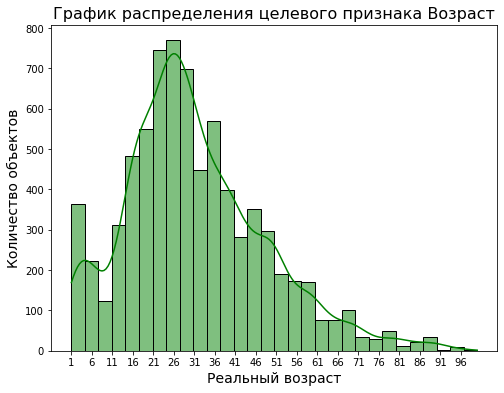

In [6]:
plt.figure(figsize=(8,6))
sns.histplot(df['real_age'], bins=30, kde=True, color='green')
plt.title('График распределения целевого признака Возраст', fontsize=16)
plt.xticks(np.arange(df['real_age'].min(), df['real_age'].max() + 1, 5))
plt.xlabel('Реальный возраст', fontsize=14)
plt.ylabel('Количество объектов', fontsize=14)
plt.show()

Распределение возраста близко к нормальному. Наблюдается асимметрия справа - длинный хвост. Пиковые значения в диапазоне от 20 до 30 лет. Присутствуют некоторого рода аномалии слева: детей в возрасте от 1 до 5 лет неожиданно много, тогда как в возрасте 8-13 лет мы наблюдаем провал. Такой дисбаланс данных может негативно сказаться на предсказаниях модели в данном диапазоне: например, ее ответы могут переходить в сторону пиковых (18-30лет). Так или иначе, доподленно неизвестны задачи построения модели, возможно заказчику важнее точно указывать возраст совсем маленьких детех, тогда как для тинейджеров такая точность будет лишней.

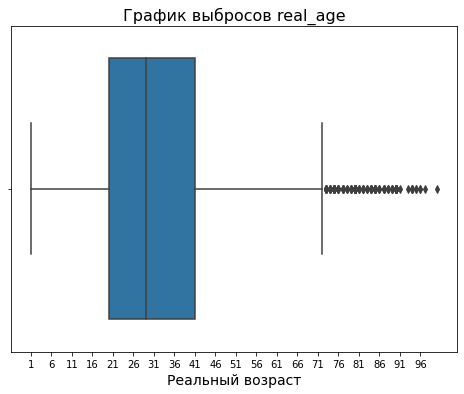

In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['real_age'])
plt.title('График выбросов real_age',fontsize=16)
plt.xticks(np.arange(df['real_age'].min(), df['real_age'].max() + 1, 5))
plt.xlabel('Реальный возраст', fontsize=14)
plt.show()

График межквартильного размаха сигнализирует нам, что как раз длинный хвост справа на графике распределения является отклонением от нормальных значений выборки. Возраст более 75 лет считается выбросами из-за редкости таких значений. Такая ситуация для данных нормальна. Если мы не можем повлиять на перекомпоновку собранных данных - лучше оставим, как есть.

### **Теперь посмотрим на изображения**

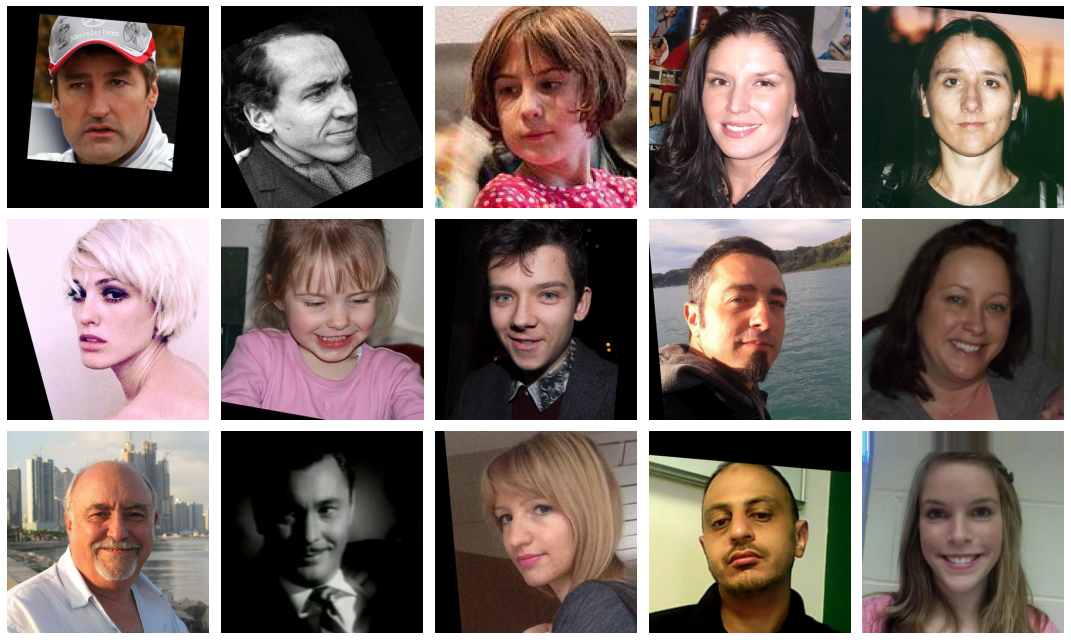

In [11]:
image_files = os.listdir(os.path.join(img_path))[:15]

nrows, ncols = 3, 5  
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 9))

for i, img_name in enumerate(image_files):
    row, col = divmod(i, ncols) 
    img = Image.open(os.path.join(img_path, img_name))
    axes[row, col].imshow(img)
    axes[row, col].axis("off")  

for ax in axes.flatten()[len(image_files):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Видим, что в датасете также присутствуют и черно-белые фото помимо rgb. Изображения часто под разным углом, разная яркость.

In [12]:
def check_images_in_directory(directory, target_size=(224, 224), max_images=20):
    count = 0
    for filename in os.listdir(directory):
        if count >= max_images:
            break
        img_path = os.path.join(directory, filename)
        if os.path.isfile(img_path):
            with Image.open(img_path) as img:
                if img.size != target_size:
                    print(f"Изображение {filename} имеет размер {img.size}, ожидается {target_size}")
                else:
                    print(f"Изображение {filename} имеет правильный размер {img.size}")
            count += 1

img_directory = '/datasets/faces/final_files'
check_images_in_directory(img_directory)

Изображение 005226.jpg имеет размер (787, 787), ожидается (224, 224)
Изображение 007426.jpg имеет размер (462, 462), ожидается (224, 224)
Изображение 001184.jpg имеет размер (142, 142), ожидается (224, 224)
Изображение 007520.jpg имеет размер (669, 669), ожидается (224, 224)
Изображение 004415.jpg имеет размер (1035, 1035), ожидается (224, 224)
Изображение 001798.jpg имеет размер (630, 630), ожидается (224, 224)
Изображение 002797.jpg имеет размер (318, 317), ожидается (224, 224)
Изображение 004223.jpg имеет размер (747, 747), ожидается (224, 224)
Изображение 003420.jpg имеет размер (632, 632), ожидается (224, 224)
Изображение 003067.jpg имеет размер (350, 350), ожидается (224, 224)
Изображение 006282.jpg имеет размер (554, 554), ожидается (224, 224)
Изображение 002022.jpg имеет размер (311, 311), ожидается (224, 224)
Изображение 000578.jpg имеет размер (355, 355), ожидается (224, 224)
Изображение 003646.jpg имеет размер (430, 431), ожидается (224, 224)
Изображение 004896.jpg имеет раз

Проверил первые 20 изображений, все они абсолютно разных размеров.

### **Выводы**

**- Признаки распределены с небольшими выбросами и определнной аномалией в районе возраста 1-5 лет. Это может привести к ошибочным значениям в предсказаниях модели.**

**- Изображения разных цветовых моделей, с разным наклоном/яркостью/контрастностью/размером. Необходимо провести их аугментацию для качественного моделирования**

<a id=2></a>
# Глава 2 Обучение модели

```python

def load_train(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), 
        class_mode='raw',
        batch_size=32,
        seed=12345,
        subset='training',
        color_mode="rgb"
    )
    return train_datagen_flow

def load_test(path):
    dataframe = pd.read_csv(path + '/labels.csv')  
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )
    
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32, 
        seed=12345,
        subset='validation',
        color_mode="rgb"
    )
    return test_datagen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
    
    for layer in backbone.layers[-10:]:
        layer.trainable = True
    
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, steps_per_epoch=None, validation_steps=None, epochs=15):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

```

Train for 178 steps, validate for 60 steps
Epoch 1/15

2025-03-13 15:44:28.681817: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-13 15:44:29.210152: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 125s - loss: 14.6169 - mae: 14.5357 - val_loss: 15.5293 - val_mae: 15.3953
Epoch 2/15

178/178 - 113s - loss: 9.5811 - mae: 9.4988 - val_loss: 15.3174 - val_mae: 15.1721

Epoch 3/15

178/178 - 112s - loss: 8.7340 - mae: 8.6514 - val_loss: 12.6552 - val_mae: 12.5446

Epoch 4/15

178/178 - 112s - loss: 8.2833 - mae: 8.2005 - val_loss: 10.4014 - val_mae: 10.2206

Epoch 5/15

178/178 - 111s - loss: 7.8829 - mae: 7.7994 - val_loss: 9.2588 - val_mae: 9.1611

Epoch 6/15

178/178 - 113s - loss: 7.3979 - mae: 7.3145 - val_loss: 7.9575 - val_mae: 7.8988

Epoch 7/15

178/178 - 111s - loss: 7.1234 - mae: 7.0400 - val_loss: 7.0881 - val_mae: 7.0214

Epoch 8/15

178/178 - 111s - loss: 6.9703 - mae: 6.8874 - val_loss: 6.8959 - val_mae: 6.8399

Epoch 9/15

178/178 - 110s - loss: 6.6249 - mae: 6.5417 - val_loss: 6.9957 - val_mae: 6.9461

Epoch 10/15

178/178 - 113s - loss: 6.4267 - mae: 6.3433 - val_loss: 7.5888 - val_mae: 7.5091

Epoch 11/15

178/178 - 113s - loss: 6.2416 - mae: 6.1585 - val_loss: 7.5110 - val_mae: 7.4620

Epoch 12/15

178/178 - 106s - loss: 6.1875 - mae: 6.1043 - val_loss: 6.8541 - val_mae: 6.7932

Epoch 13/15

178/178 - 101s - loss: 5.9508 - mae: 5.8669 - val_loss: 9.4395 - val_mae: 9.3829

Epoch 14/15

178/178 - 101s - loss: 5.8603 - mae: 5.7765 - val_loss: 7.4953 - val_mae: 7.4503

Epoch 15/15

178/178 - 101s - loss: 5.6674 - mae: 5.5839 - val_loss: 7.1577 - val_mae: 7.0948

60/60 - 11s - loss: 7.1577 - mae: 7.0948

<a id=3></a>
# Глава 3 Анализ обученной модели

**Бизнес-задачей данного проекта являлась разработка модели, которая по фотографии определит приблизительный возраст человека, что позволит применить ее в фотофиксации в прикассовой зоне. Это поможет компании анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; контролировать добросовестность кассиров при продаже алкоголя. 
Важным условием являлось достижение значения метрики эффективности модели MAE не больше 8.**

*Для решения данной проблемы я использовал архитектуру нейронной сети ResNet50*

1) **В результате проведения должной аугментации и работы с гиперпараметрами модели и ее слоями мне удалось добиться метрики MAE = 7, что означает, что моя модель в среднем может ошибаться на 7 лет в предсказаниях возраста. Ошибки, вероятнее всего, концентрируются в уже описанных в исследовательском анализе местах: между 8 и 13 годами и после 71, где у нас пристуствует низкая концентрация объектов исследования**
- собрать более качесвенную выборку данных или же, иными словами, дополнить существующую для нормальизации распределения признаков;
- если жертвовать скоростью в пользу более длительного обучения модели, то можно улучшить метрику еще.

2) **В задаче не была указана важность скорости работы модели, поэтому я сделал выбор в пользу более долгого обучения, но с более хорошим результатом метрики MAE. Также можно было ограничиться выбором 10 эпох и разморозить только 5 слоев ResNet, что позволило бы пройти заданный порог MAE < 8. В данном случае модель обучалась значительно быстрее.**

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы